https://www.kaggle.com/competitions/rossmann-store-sales/data?select=store.csv

In [1]:
import numpy as np 
import scipy.stats as ss
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import pandas as pd
import datetime

In [2]:

import torch
import subprocess

def GPU():
    if torch.cuda.is_available() == True:
        device = 'cuda'
        templist = [1, 2, 3]
        templist = torch.FloatTensor(templist).to(device)
        print("Cuda torch working : ", end="")
        print(templist.is_cuda)
        print("current device no. : ", end="")
        print(torch.cuda.current_device())
        print("GPU device count : ", end="")
        print(torch.cuda.device_count())
        print("GPU name : ", end="")
        print(torch.cuda.get_device_name(0))
        print("device : ", device)
        # Execute the nvidia-smi command using subprocess
        try:
            output = subprocess.check_output(['nvidia-smi']).decode('utf-8')
            print("nvidia-smi output:")
            print(output)
        except (subprocess.CalledProcessError, FileNotFoundError) as e:
            print("Error executing nvidia-smi command:", str(e))
    elif torch.backends.mps.is_available() == True:
        print("Apple device detected\nActivating Apple Silicon GPU")
        device = torch.device("mps")
    else:
        print("cant use gpu , activating cpu")
        device = 'cpu'

    return device
device = GPU()
print(device)

Apple device detected
Activating Apple Silicon GPU
mps


In [3]:
# 데이터 불러오기
try:
    past_sales = pd.read_csv('C:/Users/Administrator/Desktop/딥러닝/rossmann.csv')
    store = pd.read_csv('C:/Users/Administrator/Desktop/딥러닝/store.csv')
except:
    train = pd.read_csv('train.csv')
    store = pd.read_csv('store.csv')

# 데이터 제거
store = store.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis=1)

# 데이터 병합
data = pd.merge(left = train,right = store, on = 'Store', how = 'right')

# 날짜
data['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d")
data['Month']=pd.DatetimeIndex(data.Date).month
data['Day']=pd.DatetimeIndex(data.Date).day
data = data.drop(['Date'],axis=1)

# 데이터 가공 : StateHoliday
data['StateHoliday'] = data['StateHoliday'].replace({0:'d'}) # 0 값은 d로 대체
data['StateHoliday'] = data['StateHoliday'].replace({'0':'d'})# 0 값은 d로 대체


# 결측값 처리
data = data.dropna(axis=0)

# store 이름 제거
data = data.drop(['Store'],axis=1)

# 데이터 분리(수치형, 범주형)
digital_cols = ['Sales', 'Customers', 'CompetitionDistance', 'Month', 'Day']
digital_data = data[digital_cols]
digital_data = pd.DataFrame(digital_data.values, columns = digital_cols)

# 표준화
scaler = StandardScaler().fit(digital_data)
digital_data = pd.DataFrame(scaler.transform(digital_data),index = digital_data.index, columns = digital_cols)

categorey_clos = data.columns.drop(digital_cols)
categorey_data = data[categorey_clos]
categorey_data = pd.DataFrame(categorey_data.values, columns = categorey_clos)

# 인코딩
onehotencoding_cols = ['StateHoliday', 'StoreType', 'Assortment', 'DayOfWeek']
categorey_data = pd.get_dummies(data = categorey_data, columns = onehotencoding_cols)

# 데이터 병합
data = pd.concat([digital_data, categorey_data], axis = 1)

# 형 통일
data = data.astype({'Promo2':'int', 'StateHoliday_b':'int', 'StateHoliday_c':'int', 'StateHoliday_d':'int', 'StoreType_a':'int', 'StoreType_b':'int', 'StoreType_c':'int', 'StoreType_d':'int'})
data = data.astype({'Assortment_a':'int', 'Assortment_b':'int', 'Assortment_c':'int', 'DayOfWeek_1':'int', 'DayOfWeek_2':'int', 'DayOfWeek_3':'int', 'DayOfWeek_4':'int', 'DayOfWeek_5':'int', 'DayOfWeek_6':'int', 'DayOfWeek_7':'int'})

pd.options.display.max_columns = None
print(data.columns)


/var/folders/sb/2gzn9_qx589_ft0jp8q6nbbc0000gn/T/ipykernel_95708/1288668783.py:6: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('train.csv')
/var/folders/sb/2gzn9_qx589_ft0jp8q6nbbc0000gn/T/ipykernel_95708/1288668783.py:47: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  categorey_data = pd.get_dummies(data = categorey_data, columns = onehotencoding_cols)


Index(['Sales', 'Customers', 'CompetitionDistance', 'Month', 'Day', 'Open',
       'Promo', 'SchoolHoliday', 'Promo2', 'StateHoliday_a', 'StateHoliday_b',
       'StateHoliday_c', 'StateHoliday_d', 'StoreType_a', 'StoreType_b',
       'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b',
       'Assortment_c', 'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7'],
      dtype='object')


In [4]:
target_col = 'Sales'
features_cols = data.columns.drop(target_col)
features = data[features_cols]
target = data[target_col]
target = pd.DataFrame(target.values.reshape(-1,1))
features = features.values
target = target.values

In [5]:
# 80/20
x_train, x_test, y_train, y_test = train_test_split(features, target,shuffle=True)

In [6]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)


In [7]:
BATCH_SIZE = 128 ## WARNING reduce if crash or lag
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


# Model

In [8]:
#드랍아웃
DropOut = 0.2 #drop out ratio

import torch
import torch.nn as nn

# Define Model by Class
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(x_train.shape[1], 128),
            nn.ReLU(),
            nn.Dropout(DropOut),
            nn.BatchNorm1d(128)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(DropOut),
            nn.BatchNorm1d(128)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(DropOut),
            nn.BatchNorm1d(128)
        )
        self.layer4 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

model = Model().to(device)

In [9]:
import torch.optim as optim
# 손실 함수와 옵티마이저를 설정합니다.
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [10]:
NUM_EPOCHS = 20

import time


# Initialize variables for tracking progress
train_losses = []
test_losses = []
min_test_loss = np.inf
start_time = time.time()
print(device)
# Train the model
for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluation phase
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    if test_loss < min_test_loss:
        min_test_loss = test_loss
        torch.save(model.state_dict(), 'best_model.pth')

    elapsed_time = time.time() - start_time
    estimated_time = elapsed_time / (epoch+1) * NUM_EPOCHS
    remaining_time = estimated_time - elapsed_time

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}, Elapsed Time: {elapsed_time:.2f}s, Remaining Time: {remaining_time:.2f}s')

mps
Epoch: 1/20, Train Loss: 0.105541, Test Loss: 0.073583, Elapsed Time: 129.03s, Remaining Time: 2451.57s
Epoch: 2/20, Train Loss: 0.087274, Test Loss: 0.069094, Elapsed Time: 255.59s, Remaining Time: 2300.34s
Epoch: 3/20, Train Loss: 0.082980, Test Loss: 0.070058, Elapsed Time: 383.15s, Remaining Time: 2171.19s
Epoch: 4/20, Train Loss: 0.081808, Test Loss: 0.075239, Elapsed Time: 510.60s, Remaining Time: 2042.40s
Epoch: 5/20, Train Loss: 0.080528, Test Loss: 0.069172, Elapsed Time: 639.08s, Remaining Time: 1917.25s
Epoch: 6/20, Train Loss: 0.079326, Test Loss: 0.078735, Elapsed Time: 765.22s, Remaining Time: 1785.51s


KeyboardInterrupt: 

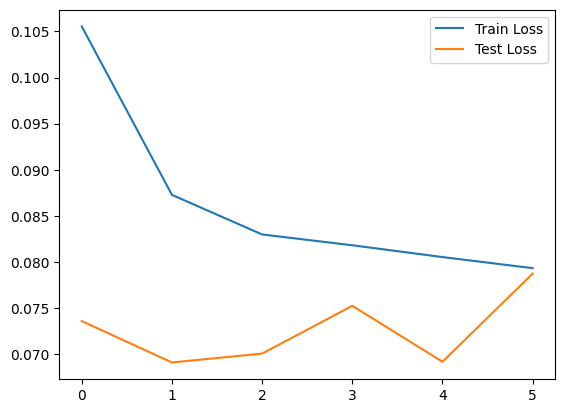

In [11]:
import matplotlib.pyplot as plt

# Plot the train and test losses
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()

In [12]:
from sklearn.metrics import r2_score, mean_squared_error

# Model loading
best_model = Model().to(device)
best_model.load_state_dict(torch.load('best_model.pth'))

# Evaluation phase
best_model.eval()
predictions = []
targets = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        output = best_model(inputs)
        predictions.append(output.detach().cpu().numpy())
        targets.append(labels.detach().cpu().numpy())

# Flattening the list of predictions and targets
predictions = np.concatenate(predictions).ravel()
targets = np.concatenate(targets).ravel()

# Calculating RMSE and R2 score
rmse = np.sqrt(mean_squared_error(targets, predictions))
r2 = r2_score(targets, predictions)

print(f"RMSE: {rmse:.6f}, R2 Score: {r2:.6f}")

RMSE: 0.262858, R2 Score: 0.930830


# Making submission

In [13]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# test 데이터 불러오기
# 데이터 불러오기

try:
    test = pd.read_csv('C:/Users/Administrator/Desktop/딥러닝/test.csv')
    store = pd.read_csv('C:/Users/Administrator/Desktop/딥러닝/store.csv')
except:
    test = pd.read_csv('test.csv')
    store = pd.read_csv('store.csv')

# 데이터 제거
store = store.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis=1)


# 데이터 병합
test_data = pd.merge(left = test, right = store, on = 'Store', how = 'right')

# 날짜 처리
test_data['Date'] = pd.to_datetime(test_data['Date'], format="%Y-%m-%d")
test_data['Month'] = pd.DatetimeIndex(test_data.Date).month
test_data['Day'] = pd.DatetimeIndex(test_data.Date).day
test_data = test_data.drop(['Date'], axis=1)

# StateHoliday 데이터 처리
test_data['StateHoliday'] = test_data['StateHoliday'].replace({0: 'd'})
test_data['StateHoliday'] = test_data['StateHoliday'].replace({'0': 'd'})

# 결측값 처리
test_data = test_data.dropna(axis=0)

# 'Store' 컬럼 제거
test_data = test_data.drop(['Store'], axis=1)

# 데이터 분리(수치형, 범주형)
digital_cols = ['CompetitionDistance', 'Month', 'Day']
digital_data = test_data[digital_cols]
digital_data = pd.DataFrame(digital_data.values, columns = digital_cols)
print(test_data.head(2))

      Id  DayOfWeek  Open  Promo StateHoliday  SchoolHoliday StoreType  \
0    1.0        4.0   1.0    1.0            d            0.0         c   
1  857.0        3.0   1.0    1.0            d            0.0         c   

  Assortment  CompetitionDistance  Promo2  Month   Day  
0          a               1270.0       0    9.0  17.0  
1          a               1270.0       0    9.0  16.0  


In [14]:
# 표준화
scaler = StandardScaler().fit(digital_data)
digital_data = pd.DataFrame(scaler.transform(digital_data),index = digital_data.index, columns = digital_cols)

categorey_clos = test_data.columns.drop(digital_cols)
categorey_data = test_data[categorey_clos]
categorey_data = pd.DataFrame(categorey_data.values, columns = categorey_clos)



# 원핫 인코딩
all_possible_categories = ['a', 'b', 'c', 'd'] # 모든 가능한 범주

categorey_data['StateHoliday'] = pd.Categorical(categorey_data['StateHoliday'], categories=all_possible_categories)

onehotencoding_cols = ['StateHoliday', 'StoreType', 'Assortment', 'DayOfWeek']

categorey_data = pd.get_dummies(data = categorey_data, columns = onehotencoding_cols)


/var/folders/sb/2gzn9_qx589_ft0jp8q6nbbc0000gn/T/ipykernel_95708/267682438.py:18: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  categorey_data = pd.get_dummies(data = categorey_data, columns = onehotencoding_cols)


In [15]:
# 데이터 병합
test_data = pd.concat([digital_data,categorey_data],axis=1)

In [16]:
print(test_data.head(3))

   CompetitionDistance     Month       Day      Id Open Promo SchoolHoliday  \
0            -0.528494  1.350381  0.411816     1.0  1.0   1.0           0.0   
1            -0.528494  1.350381  0.293450   857.0  1.0   1.0           0.0   
2            -0.528494  1.350381  0.175084  1713.0  1.0   1.0           0.0   

  Promo2  StateHoliday_a  StateHoliday_b  StateHoliday_c  StateHoliday_d  \
0      0               0               0               0               1   
1      0               0               0               0               1   
2      0               0               0               0               1   

   StoreType_a  StoreType_b  StoreType_c  StoreType_d  Assortment_a  \
0            0            0            1            0             1   
1            0            0            1            0             1   
2            0            0            1            0             1   

   Assortment_b  Assortment_c  DayOfWeek_1.0  DayOfWeek_2.0  DayOfWeek_3.0  \
0             0

In [17]:
print(test_data.columns)

Index(['CompetitionDistance', 'Month', 'Day', 'Id', 'Open', 'Promo',
       'SchoolHoliday', 'Promo2', 'StateHoliday_a', 'StateHoliday_b',
       'StateHoliday_c', 'StateHoliday_d', 'StoreType_a', 'StoreType_b',
       'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b',
       'Assortment_c', 'DayOfWeek_1.0', 'DayOfWeek_2.0', 'DayOfWeek_3.0',
       'DayOfWeek_4.0', 'DayOfWeek_5.0', 'DayOfWeek_6.0', 'DayOfWeek_7.0'],
      dtype='object')


In [18]:


#all to int
# 형 통일
test_data = test_data.astype({'Promo2':'int',
                            'StateHoliday_b':'int',
                            'StateHoliday_c':'int',
                            'StateHoliday_d':'int',
                            'StoreType_a':'int',
                            'StoreType_b':'int',
                            'StoreType_c':'int',
                            'StoreType_d':'int'})
test_data = test_data.astype({'Assortment_a':'int',
                            'Assortment_b':'int',
                            'Assortment_c':'int',
                            'DayOfWeek_1.0':'int',
                            'DayOfWeek_2.0':'int',
                            'DayOfWeek_3.0':'int',
                            'DayOfWeek_4.0':'int',
                            'DayOfWeek_5.0':'int',
                            'DayOfWeek_6.0':'int',
                            'DayOfWeek_7.0':'int'})

pd.options.display.max_columns = None
print(test_data.head(3))



   CompetitionDistance     Month       Day      Id Open Promo SchoolHoliday  \
0            -0.528494  1.350381  0.411816     1.0  1.0   1.0           0.0   
1            -0.528494  1.350381  0.293450   857.0  1.0   1.0           0.0   
2            -0.528494  1.350381  0.175084  1713.0  1.0   1.0           0.0   

   Promo2  StateHoliday_a  StateHoliday_b  StateHoliday_c  StateHoliday_d  \
0       0               0               0               0               1   
1       0               0               0               0               1   
2       0               0               0               0               1   

   StoreType_a  StoreType_b  StoreType_c  StoreType_d  Assortment_a  \
0            0            0            1            0             1   
1            0            0            1            0             1   
2            0            0            1            0             1   

   Assortment_b  Assortment_c  DayOfWeek_1.0  DayOfWeek_2.0  DayOfWeek_3.0  \
0          

In [22]:
import torch

device = 'mps'

# pandas DataFrame을 numpy 배열로 변환
test_values = test_data.values.astype('float32')

# numpy 배열을 PyTorch Tensor로 변환
test_tensor = torch.tensor(test_values, dtype=torch.float32).to(device)



# Load model
# Model loading
best_model = Model().to(device)
best_model.load_state_dict(torch.load('best_model.pth'))

## model shape

print(x_test_tensor.shape)

# 예측 수행
model.eval()
with torch.no_grad():
    predictions = model(test_tensor)

# 예측 결과를 Numpy 배열로 변환
predictions = predictions.cpu().numpy()

# 예측 결과를 원래의 스케일로 변환
#predictions = scaler.inverse_transform(predictions)
print(predictions.shape)

# Id와 예측 값을 포함하는 데이터프레임 생성
submission = pd.DataFrame({'Id': test['Id'], 'Sales': predictions.flatten()})

# csv 파일로 저장
submission.to_csv('submission.csv', index=False)

torch.Size([253642, 26])
(40992, 1)


ValueError: array length 40992 does not match index length 41088